**TABLE OF CONTENTS**

In [1]:
# The libraries we will use are imported here, in case of runtime problems
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import scipy as sp
from tensorflow import keras
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Random seed to repeat experiments.
np.random.seed(42)
tf.random.set_seed(42)

# Dataset preparation

In [3]:
files = []
#read all files
for file in os.listdir('./dependency_treebank'):
    if file.endswith(".dp"):
        files.append(file)   

files = sorted(files)     

In [4]:
dataframe = []
for filename in sorted(os.listdir('./dependency_treebank')):
    word_list = []
    label_list = []
    # open the file
    with open(f'dependency_treebank/{filename}', mode='r', encoding='utf-8') as text_file:
        a = True
        while a:
            line = text_file.readline()
            if line.strip():
                #The line is NOT empty'
                words = line.split()
                word_list.append(words[0].lower())
                label_list.append(words[1]) 
            else:
                #The line is empty
                dataframe.append({"file_id": int(filename[5:8]), "words": list(word_list), "labels": list(label_list)}) 
                word_list = []
                label_list = []
            
            if not line:
                word_list = []
                label_list = []
                a = False


In [6]:
# let's look at first five data points
number_of_samples = 5
samples = dataframe[:number_of_samples]
for s in samples:
    print('sample X: ', s['words'])
    print('sample Y: ', s['labels'], '\n')


sample X:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']
sample Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 

sample X:  ['mr.', 'vinken', 'is', 'chairman', 'of', 'elsevier', 'n.v.', ',', 'the', 'dutch', 'publishing', 'group', '.']
sample Y:  ['NNP', 'NNP', 'VBZ', 'NN', 'IN', 'NNP', 'NNP', ',', 'DT', 'NNP', 'VBG', 'NN', '.'] 

sample X:  ['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '.']
sample Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', 'CC', 'JJ', 'NN', 'IN', 'NNP', 'NNP', 'NNP', 'NNP', ',', 'VBD', 'VBN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', '.'] 

sample X:  ['a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent'

In this many-to-many problem, the length of each input and output sequence must be the same. Since each word is tagged, it's important to make sure that the length of input sequence equals the output sequence

In [7]:
for i in range(len(samples)):
    print("Length of {}' input sequence : {}".format(i+1, len(samples[i]['words'])))
    print("Length of {}' output sequence: {}\n".format(i+1, len(samples[i]['labels'])))


Length of 1' input sequence : 18
Length of 1' output sequence: 18

Length of 2' input sequence : 13
Length of 2' output sequence: 13

Length of 3' input sequence : 26
Length of 3' output sequence: 26

Length of 4' input sequence : 36
Length of 4' output sequence: 36

Length of 5' input sequence : 32
Length of 5' output sequence: 32



# Dataframe creation

In [8]:
def set_split(x):
    if x < 101:
        return 'train'
    elif x < 151:
        return 'val'
    else:
        return 'test'

In [9]:
df = pd.DataFrame(dataframe)
df['split'] = df['file_id'].map(lambda x: set_split(x))
df

,file_id,words,labels,split
0,1,"[pierre, vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ...",train
1,1,"[mr., vinken, is, chairman, of, elsevier, n.v....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ...",train
2,2,"[rudolph, agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...",train
3,3,"[a, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...",train
4,3,"[the, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V...",train
...,...,...,...,...
3909,198,"[they, also, said, that, more, than, a, dozen,...","[PRP, RB, VBD, IN, JJR, IN, DT, NN, NNS, VBP, ...",test
3910,198,"[sen., kennedy, said, in, a, separate, stateme...","[NNP, NNP, VBD, IN, DT, JJ, NN, IN, PRP, VBZ, ...",test
3911,199,"[trinity, industries, inc., said, it, reached,...","[NNP, NNPS, NNP, VBD, PRP, VBD, DT, JJ, NN, TO...",test
3912,199,"[terms, were, n't, disclosed, .]","[NNS, VBD, RB, VBN, .]",test


# Dataset Analysis

In [10]:
df2 = df.explode(['labels', 'words'])
df2

,file_id,words,labels,split
0,1,pierre,NNP,train
0,1,vinken,NNP,train
0,1,",",",",train
0,1,61,CD,train
0,1,years,NNS,train
...,...,...,...,...
3913,199,quarter,NN,test
3913,199,of,IN,test
3913,199,next,JJ,test
3913,199,year,NN,test


## Labels distribution

In [11]:
column = 'labels'
print("Distribution of labels: ")
print(df2[column].value_counts())
print()

Distribution of labels: 
NN       13166
IN        9857
NNP       9410
DT        8165
NNS       6047
JJ        5834
,         4886
.         3874
CD        3546
VBD       3043
RB        2822
VB        2554
CC        2265
TO        2179
VBN       2134
VBZ       2125
PRP       1716
VBG       1460
VBP       1321
MD         927
POS        824
PRP$       766
$          724
``         712
''         694
:          563
WDT        445
JJR        381
NNPS       244
WP         241
RP         216
JJS        182
WRB        178
RBR        136
-RRB-      126
-LRB-      120
EX          88
RBS         35
PDT         27
#           16
WP$         14
LS          13
FW           4
UH           3
SYM          1
Name: labels, dtype: int64



## Labels distribution in train set

In [12]:
df_train = df2[df2.split == 'train']
print("Distribution of labels in train set: ")
print(df_train[column].value_counts())
print()

Distribution of labels in train set: 
NN       6270
NNP      5202
IN       4952
DT       4076
NNS      3004
JJ       2992
,        2571
.        1959
VBD      1548
RB       1490
CD       1439
VB       1195
CC       1141
VBZ      1133
VBN      1031
TO       1028
PRP       954
VBG       763
VBP       727
MD        413
PRP$      409
``        409
POS       403
''        399
$         342
:         293
WDT       204
JJR       157
WP        141
RP        140
NNPS       95
JJS        93
WRB        92
RBR        86
-RRB-      55
-LRB-      52
EX         49
RBS        19
LS         10
PDT         9
WP$         6
FW          2
UH          1
SYM         1
#           1
Name: labels, dtype: int64



## Labels distribution in validation set

In [13]:
df_val = df2[df2.split == 'val']
print("Distribution of labels in validation set: ")
print(df_val[column].value_counts())
print()

Distribution of labels in validation set: 
NN       4513
IN       3275
DT       2754
NNP      2704
NNS      2102
JJ       1924
,        1528
.        1277
CD       1249
VB        956
RB        951
VBD       861
TO        765
CC        758
VBN       737
VBZ       712
PRP       570
VBG       476
VBP       460
MD        347
POS       269
PRP$      258
``        230
''        225
:         214
$         173
JJR       165
WDT       157
NNPS      105
WP         80
WRB        62
JJS        58
-RRB-      53
-LRB-      50
RP         43
RBR        35
EX         34
#          15
PDT        14
RBS        13
WP$         4
LS          3
FW          2
UH          2
Name: labels, dtype: int64



## Labels distribution in test set

In [14]:
df_test = df2[df2.split == 'test']
print("Distribution of labels in test set: ")
print(df_test[column].value_counts())
print()

Distribution of labels in test set: 
NN       2383
IN       1630
NNP      1504
DT       1335
NNS       941
JJ        918
CD        858
,         787
.         638
VBD       634
VB        403
TO        386
RB        381
CC        366
VBN       366
VBZ       280
VBG       221
$         209
PRP       192
MD        167
POS       152
VBP       134
PRP$       99
WDT        84
``         73
''         70
JJR        59
:          56
NNPS       44
RP         33
JJS        31
WRB        24
WP         20
-LRB-      18
-RRB-      18
RBR        15
EX          5
WP$         4
PDT         4
RBS         3
Name: labels, dtype: int64



## Visualization of labels distribution

In [15]:
sorted_labels = np.unique(sorted(df_train.labels))

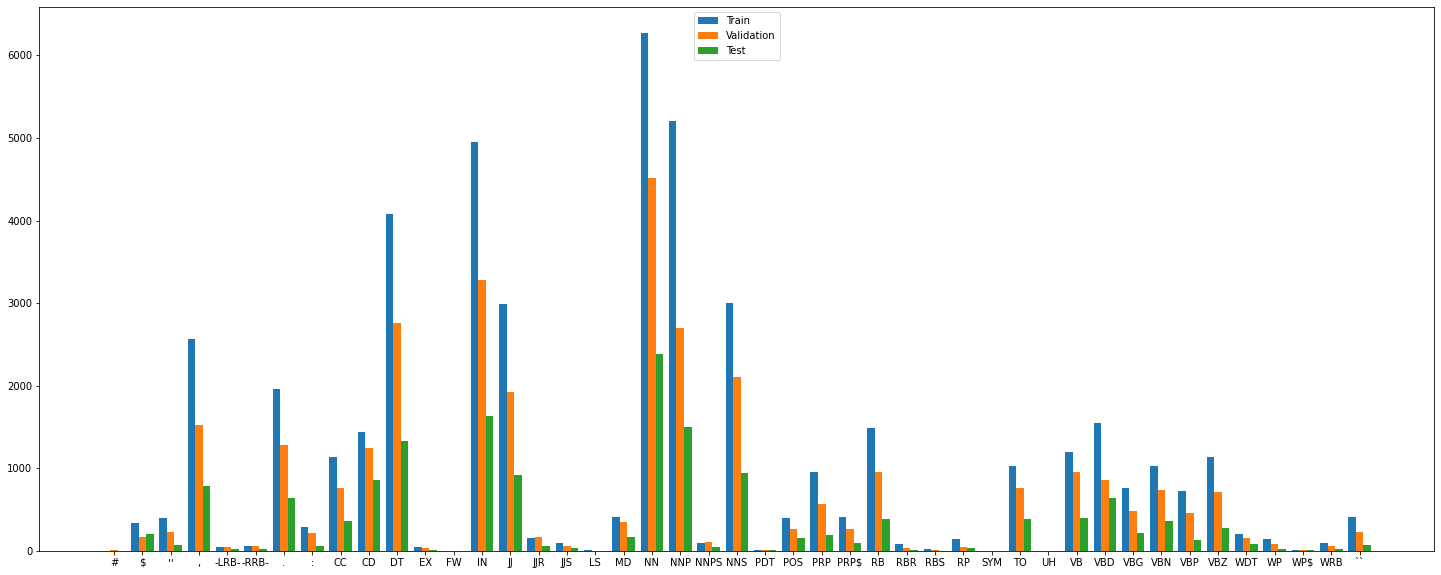

In [16]:
plt.figure(figsize=(25,10))

def get_values(data):
    return data.labels.value_counts(sort = False).reindex(sorted_labels, fill_value=0).values

def subcategorybar(X, vals, width=0.8):
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align="edge")   
    plt.xticks(_X, X)

x_ax = sorted_labels  
y1_ax = get_values(df_train)
y2_ax = get_values(df_val)
y3_ax = get_values(df_test)
subcategorybar(x_ax, [y1_ax,y2_ax,y3_ax])

plt.legend(["Train", "Validation", "Test"], loc='upper center')
plt.show()

In [17]:
def plot_bar(data, color, title):
    plt.figure(figsize=(15,5))
    plt.title(title)
    data.labels.value_counts(sort = False).reindex(sorted_labels, fill_value=0).plot.bar(color=color)

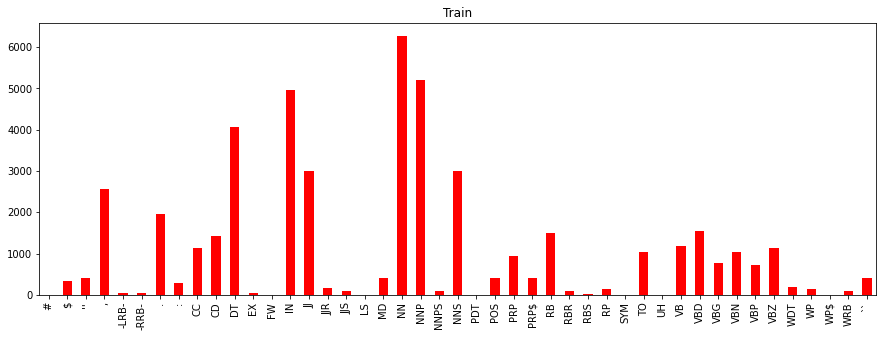

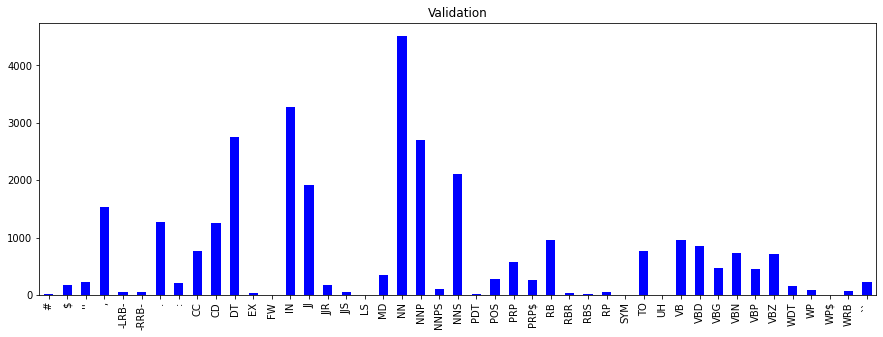

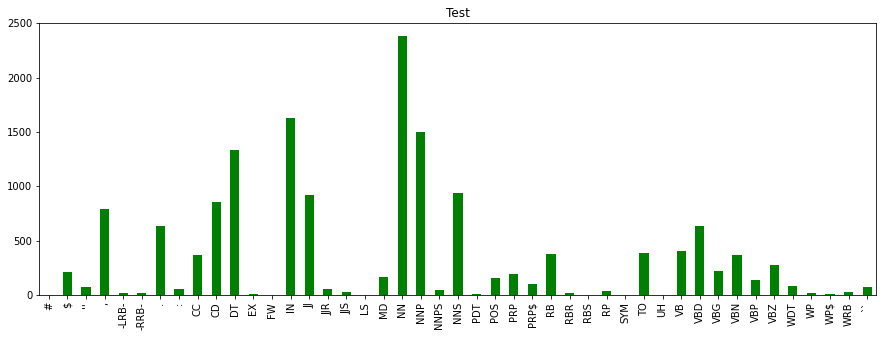

In [18]:
plot_bar(df_train, "red", "Train")
plot_bar(df_val, "blue", "Validation")
plot_bar(df_test, "green", "Test")

# Words and labels vectorization
To encode the text sequence to an integer sequence, we will use the **Tokenizer()** function from the Keras library. It's important to note that best practice is to fit the tokenizer on the training data only, to avoid introducing data leakage in the model. However, in our particular case, we are not considering a real-world scenario and have limited data at our disposal. Therefore, we are fitting the tokenizer over the entire dataset.

In [19]:
from keras.preprocessing.text import Tokenizer
# words encoding 
word_tokenizer = Tokenizer(filters = '\t\n')                       # instantiate tokeniser
word_tokenizer.fit_on_texts(df['words'])                           # fit tokeniser on data
sentences_encoded = word_tokenizer.texts_to_sequences(df['words']) # use the tokeniser to encode input sequence

In [20]:
# labels encoding 
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(df['labels'])
labels_encoded = label_tokenizer.texts_to_sequences(df['labels'])

In [21]:
# look at first encoded data point
for i in range(3): 
    print(f"** Raw data point {i+1} **")
    print('X: ', samples[i]['words'])
    print('Y: ', samples[i]['labels'], '\n')

    print(f"** Encoded data point {i+1} **")
    print('X: ', sentences_encoded[i])
    print('Y: ', labels_encoded[i], '\n')
    print("-"*100)

** Raw data point 1 **
X:  ['pierre', 'vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov.', '29', '.']
Y:  ['NNP', 'NNP', ',', 'CD', 'NNS', 'JJ', ',', 'MD', 'VB', 'DT', 'NN', 'IN', 'DT', 'JJ', 'NN', 'NNP', 'CD', '.'] 

** Encoded data point 1 **
X:  [5419, 3714, 1, 2005, 78, 316, 1, 39, 2383, 2, 122, 22, 6, 2006, 317, 444, 2007, 3]
Y:  [3, 3, 7, 9, 5, 6, 7, 20, 12, 4, 1, 2, 4, 6, 1, 3, 9, 8] 

----------------------------------------------------------------------------------------------------
** Raw data point 2 **
X:  ['mr.', 'vinken', 'is', 'chairman', 'of', 'elsevier', 'n.v.', ',', 'the', 'dutch', 'publishing', 'group', '.']
Y:  ['NNP', 'NNP', 'VBZ', 'NN', 'IN', 'NNP', 'NNP', ',', 'DT', 'NNP', 'VBG', 'NN', '.'] 

** Encoded data point 2 **
X:  [26, 3714, 15, 167, 4, 5420, 2890, 1, 2, 2891, 621, 137, 3]
Y:  [3, 3, 16, 1, 2, 3, 3, 7, 4, 3, 18, 1, 8] 

--------------------------------------------------------------------

In [22]:
# make sure that each sequence of input and output is same length
different_length = [1 if len(input) != len(output) else 0 for input, output in zip(sentences_encoded, labels_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


# Pad sequences
The next step after encoding the data is to **define the sequence lengths**. As of now, the sentences present in the data are of various lengths. We need to either pad short sentences or truncate long sentences to a fixed length. This fixed length, however, is a **hyperparameter**.

In [23]:
# check length of longest sentence
lengths = [len(seq) for seq in sentences_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 249


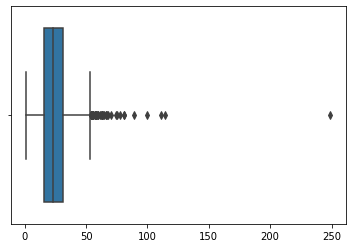

In [24]:
sns.boxplot(x = lengths)
plt.show()

Pad each sequence to **MAX_SEQ_LENGTH** using KERAS' *pad_sequences( )* function:  
- Sentences longer than MAX_SEQ_LENGTH are truncated.
- Sentences shorter than MAX_SEQ_LENGTH are padded with zeroes.

Truncation and padding can either be 'pre' or 'post': 
- For **padding** we are using **'post'** padding type, that is, add zeroes on the right side.
- For **truncation**, we are using **'post'**, that is, truncate a sentence from right side.

In [25]:
MAX_SEQ_LENGTH = 60  # sequences greater than 60 in length will be truncated

X_padded = pad_sequences(sentences_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")
Y_padded = pad_sequences(labels_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

In [26]:
# print the first sequence
print(X_padded[0], "\n"*3)
print(Y_padded[0])

[5419 3714    1 2005   78  316    1   39 2383    2  122   22    6 2006
  317  444 2007    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0] 



[ 3  3  7  9  5  6  7 20 12  4  1  2  4  6  1  3  9  8  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0]


In [27]:
# assign padded sequences to X and Y
X, y = X_padded, Y_padded

# Word and label embeddings
Currently, each word and each label is encoded as an integer, but we need a better representation. For this reason we will use: 
- **word embeddings** with **GloVe model** to represent the input words 
- **one-hot encoding** to represent each label

## 1. GloVe embedding for input words

### Create a vocabulary index
Let's use the Tokenizer to index the vocabulary found in the dataset. 

In [28]:
def get_word_index(df):
    tokenizer = Tokenizer(filters = '\t\n')
    tokenizer.fit_on_texts(df)
    word_index = tokenizer.word_index
    return word_index

### Load pre-trained GloVe embeddings

In [29]:
import gensim.downloader as api
glove = api.load('glove-wiki-gigaword-300')
print("Found %s word vectors." % len(glove.vectors))

[==================================================] 100.0% 376.1/376.1MB downloaded
Found 400000 word vectors.


### Out-Of-Vocabulary words: Random Embedding
The Out-Of-Vocabulary words (OOVs) are words which do not belong to the GloVe's vocabulary. However, we need to handle their embedding taking in mind that they must be STATIC embeddings (we cannot train them).

In this case we opted for a **random embedding** such that each OOV is represented by a vector of 300 values within -0.5 and 0.5.


### Embedding matrix
Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in the corresponding tokenizer's vocabulary.

We will compute an independent embedding for each split of the data. Therefore, if a word is present both in the training set and in the test split and not in the starting vocabulary, its embedding is computed only once (for the train split) and it is not considered as OOV twice.

In [30]:
def get_embedding_matrix(length_voc, word_index, oov_embedded = [], embedding_dim = 300 ):
    num_tokens = length_voc + 1
    hits = 0
    misses = 0

    # Prepare embedding matrix
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        if not(word in oov_embedded):
            try: 
                embedding_vector = glove.get_vector(word)
                embedding_matrix[i] = embedding_vector
                hits += 1
            except:
                #oov management
                embedding_matrix[i] = np.random.uniform(low=-0.05, high=0.05, size=embedding_dim)
                misses += 1
                oov_embedded.append(word)

    return embedding_matrix, hits, misses, oov_embedded

In [31]:
train = df.index[df.split == 'train'].to_list()
val = df.index[df.split == 'val'].to_list()
test = df.index[df.split == 'test'].to_list()

In [32]:
# Step 1: creation of vocabulary for the training set and extraction of his OOVs.
word_index_train = get_word_index(df.words.iloc[train])
print(len(word_index_train.keys()))
embedding_matrix_train, hits, misses, oov_embedded = get_embedding_matrix(len(word_index_train.keys()), word_index_train)
#print(oov_embedded)
print("Embedding matrix shape: {}".format(embedding_matrix_train.shape))
print("Converted %d words (%d misses)" % (hits, misses))

7404
Embedding matrix shape: (7405, 300)
Converted 7045 words (359 misses)


In [33]:
# Step 2: creation of vocabulary for the validation set and extraction of his OOVs.
word_index_val = get_word_index(df.words.iloc[val])

embedding_matrix_val, hits, misses, oov_embedded = get_embedding_matrix(len(word_index_val.keys()), word_index_val, oov_embedded)
print("Embedding matrix shape: {}".format(embedding_matrix_val.shape))
print("Converted %d words (%d misses)" % (hits, misses))

Embedding matrix shape: (5421, 300)
Converted 5207 words (189 misses)


In [34]:
# Step 3: creation of vocabulary for the validation set and extraction of his OOVs.
word_index_test = get_word_index(df.words.iloc[test])

embedding_matrix_test, hits, misses, oov_embedded = get_embedding_matrix(len(word_index_test.keys()), word_index_test, oov_embedded)
print("Embedding matrix shape: {}".format(embedding_matrix_test.shape))
print("Converted %d words (%d misses)" % (hits, misses))

Embedding matrix shape: (3408, 300)
Converted 3246 words (128 misses)


In [35]:
# Whole embedding matrix.
embedding_matrix = np.concatenate((embedding_matrix_train, embedding_matrix_val, embedding_matrix_test))
print("Embedding matrix shape: {}.".format(embedding_matrix.shape))

Embedding matrix shape: (16234, 300).


### Creation of the Embedding layer 

In [36]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, TimeDistributed, GRU

embedding_layer = Embedding(
    embedding_matrix.shape[0],
    300,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero = True
)

## 2. One-hot encoding for output sequences

In [37]:
# use Keras' to_categorical function to one-hot encode Y
Y = to_categorical(y)

# print Y of the first output sequqnce
print(Y.shape)

(3914, 60, 46)


# Split data in train, validation and test sets

In [38]:
X_train, Y_train = X[train], Y[train]
X_val, Y_val = X[val], Y[val]
X_test, Y_test = X[test], Y[test]

In [39]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(Y_val.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (1963, 60)
Shape of output sequences: (1963, 60, 46)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (1299, 60)
Shape of output sequences: (1299, 60, 46)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (652, 60)
Shape of output sequences: (652, 60, 46)


# General setup for training phase

## Callbacks

In [66]:
# ReduceLROnPlateau
reduce_on_plateau_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    verbose=1, 
    mode='min')

# ModelCheckpoint
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(
                            monitor = "val_loss", 
                            patience = 10,
                            verbose = 1,
                            mode = "auto")

callbacks = [
    reduce_on_plateau_callback,
    early_stopping_callbacks,
    model_checkpoint_callback,
]

## History Plot

In [41]:
def plot_history(history):
    fig = plt.figure(figsize=(15,7))
    
    ax1 = fig.add_subplot(121)
    ax1.plot(history.history['acc'])
    ax1.plot(history.history['val_acc'])
    ax1.legend(["train", "val"])
    ax1.set_title('model accuracy')
    ax1.set_xlabel('epoch') 
    ax1.set_ylabel('accuracy')

    ax2 = fig.add_subplot(122)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.legend(["train", "val"])
    ax2.set_title('model loss')
    ax2.set_xlabel('epoch') 
    ax2.set_ylabel('loss')

    plt.show()

# Baseline Model

**Model architecture**

In [110]:
## BASELINE MODEL 
tf.keras.backend.clear_session()
model = tf.keras.models.Sequential([
    embedding_layer,
    Bidirectional(LSTM(128, return_sequences=True, dropout=0.5)),
    Dense(46, activation='softmax')
])
print(model.summary())
# plot_model(model, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4870200   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        439296    
 l)                                                              
                                                                 
 dense (Dense)               (None, None, 46)          11822     
                                                                 
Total params: 5,321,318
Trainable params: 451,118
Non-trainable params: 4,870,200
_________________________________________________________________
None


**Compile model**

In [111]:
model.compile(
    loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01), metrics=["acc"]
)

**Fit model**

In [112]:
history = model.fit(X_train, 
                    Y_train, 
                    validation_data=(X_val, Y_val), 
                    batch_size=512, 
                    epochs=100, 
                    callbacks=callbacks)

Epoch 1/100
4/4 [==============================] - 14s 2s/step - loss: 1.2605 - acc: 0.1656 - val_loss: 1.0138 - val_acc: 0.3499 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 0.8886 - acc: 0.4063 - val_loss: 0.7621 - val_acc: 0.4668 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 0.6980 - acc: 0.5081 - val_loss: 0.6388 - val_acc: 0.5479 - lr: 0.0100
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 0.5955 - acc: 0.5748 - val_loss: 0.5619 - val_acc: 0.5923 - lr: 0.0100
Epoch 5/100
4/4 [==============================] - 6s 2s/step - loss: 0.5278 - acc: 0.6144 - val_loss: 0.5079 - val_acc: 0.6243 - lr: 0.0100
Epoch 6/100
4/4 [==============================] - 6s 2s/step - loss: 0.4792 - acc: 0.6398 - val_loss: 0.4658 - val_acc: 0.6457 - lr: 0.0100
Epoch 7/100
4/4 [==============================] - 6s 2s/step - loss: 0.4422 - acc: 0.6665 - val_loss: 0.4309 - val_acc: 0.6729 - lr: 0.0100
Epoch 8/100


**Plot history**

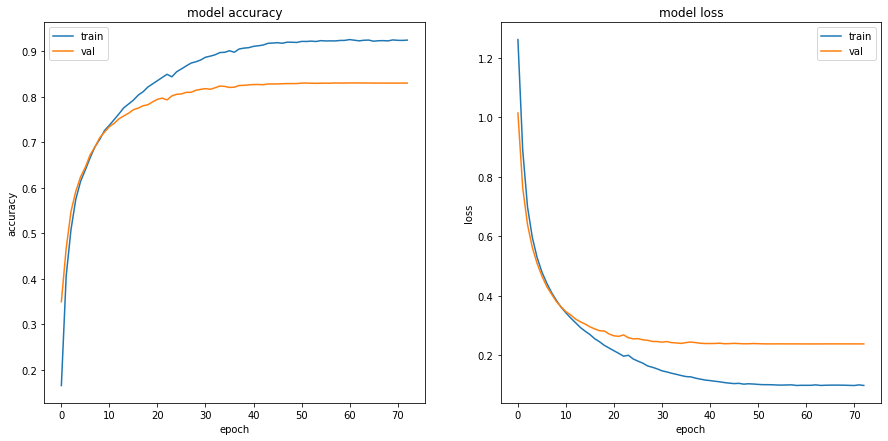

In [113]:
plot_history(history)

# Baseline Model variations

## 1. GRU layer instead of LSTM layer


**Model architecture**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4870200   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        330240    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 46)         11822     
 ibuted)                                                         
                                                                 
Total params: 5,212,262
Trainable params: 342,062
Non-trainable params: 4,870,200
_________________________________________________________________
None


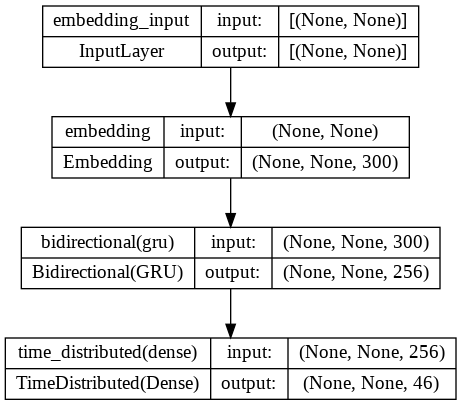

In [114]:
# MODEL VARIATION 1
tf.keras.backend.clear_session()
model_v1 = tf.keras.models.Sequential([
    embedding_layer,
    Bidirectional(GRU(128, return_sequences=True, dropout= 0.5)),
    TimeDistributed(Dense(46, activation='softmax'))
])

print(model_v1.summary())
plot_model(model_v1, show_shapes=True, show_layer_names=True)

**Compile model**

In [115]:
model_v1.compile(
    loss="categorical_crossentropy", optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=0.01), metrics=["acc"]
)

**Fit model**

In [116]:
history_v1 = model_v1.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=512, epochs=100, callbacks=callbacks)

Epoch 1/100
4/4 [==============================] - 13s 2s/step - loss: 1.4630 - acc: 0.1746 - val_loss: 1.1454 - val_acc: 0.3841 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 5s 1s/step - loss: 0.9608 - acc: 0.4320 - val_loss: 0.6976 - val_acc: 0.5267 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 5s 1s/step - loss: 0.6583 - acc: 0.5396 - val_loss: 0.5649 - val_acc: 0.5751 - lr: 0.0100
Epoch 4/100
4/4 [==============================] - 5s 1s/step - loss: 0.5343 - acc: 0.6043 - val_loss: 0.5256 - val_acc: 0.5900 - lr: 0.0100
Epoch 5/100
4/4 [==============================] - 5s 1s/step - loss: 0.4953 - acc: 0.6273 - val_loss: 0.4634 - val_acc: 0.6524 - lr: 0.0100
Epoch 6/100
4/4 [==============================] - 5s 1s/step - loss: 0.4419 - acc: 0.6668 - val_loss: 0.4776 - val_acc: 0.6480 - lr: 0.0100
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 0.4425 - acc: 0.6617 - val_loss: 0.4182 - val_acc: 0.6811 - lr: 0.0100
Epoch 8/100


**Plot history**

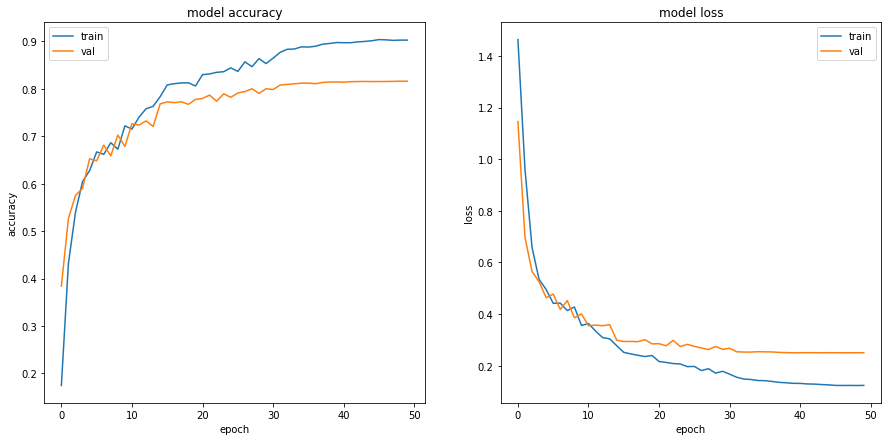

In [117]:
plot_history(history_v1)

## 2. Adding an additional LSTM layer


**Model architecture**

In [67]:
# MODEL VARIATION 2
tf.keras.backend.clear_session()
model_v2 = tf.keras.models.Sequential([
    embedding_layer,
    Bidirectional(LSTM(128, return_sequences=True, dropout= 0.5)),
    Bidirectional(LSTM(128, return_sequences=True, dropout= 0.25)),
    TimeDistributed(Dense(46, activation='softmax'))
])

print(model_v2.summary())
#plot_model(model_v2, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4870200   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, None, 46)         11822     
 ibuted)                                                         
                                                                 
Total params: 5,715,558
Trainable params: 845,358
Non-trainable params: 4,870,200
________________________________________

**Compile model**

In [68]:
model_v2.compile(
    loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01), metrics=["acc"]
)

**Fit model**

In [69]:
history_v2 = model_v2.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=512, epochs=100, callbacks=callbacks)

Epoch 1/100
4/4 [==============================] - 28s 4s/step - loss: 1.4363 - acc: 0.0948 - val_loss: 1.2912 - val_acc: 0.1448 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 12s 3s/step - loss: 1.2494 - acc: 0.1577 - val_loss: 1.1850 - val_acc: 0.2090 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 12s 3s/step - loss: 1.1393 - acc: 0.2171 - val_loss: 1.0938 - val_acc: 0.2975 - lr: 0.0100
Epoch 4/100
4/4 [==============================] - 12s 3s/step - loss: 1.0541 - acc: 0.3001 - val_loss: 0.9997 - val_acc: 0.3312 - lr: 0.0100
Epoch 5/100
4/4 [==============================] - 12s 3s/step - loss: 0.9549 - acc: 0.3743 - val_loss: 0.8970 - val_acc: 0.4095 - lr: 0.0100
Epoch 6/100
4/4 [==============================] - 12s 3s/step - loss: 0.8520 - acc: 0.4229 - val_loss: 0.7891 - val_acc: 0.4409 - lr: 0.0100
Epoch 7/100
4/4 [==============================] - 12s 3s/step - loss: 0.7533 - acc: 0.4560 - val_loss: 0.7088 - val_acc: 0.4794 - lr: 0.0100
Epoch 

Plot **history**

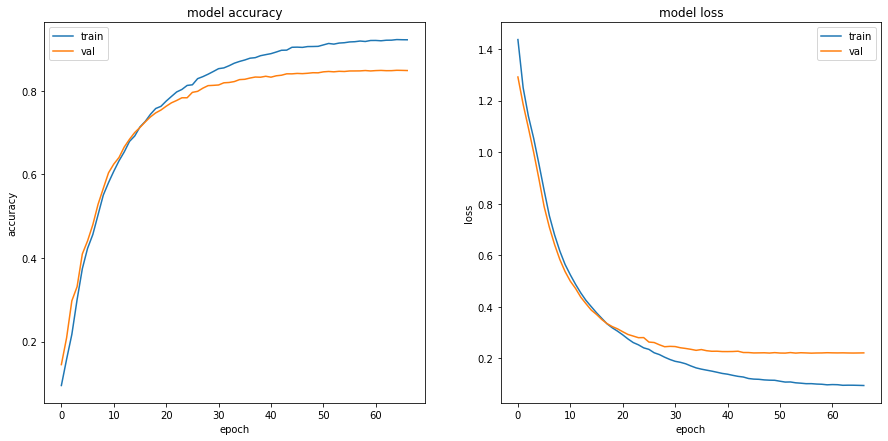

In [76]:
plot_history(history_v2)

## 3. Additional dense layer

**Model architecture**

In [123]:
# MODEL VARIATION 3
tf.keras.backend.clear_session()
model_v3 = tf.keras.models.Sequential([
    embedding_layer,
    Bidirectional(LSTM(128, return_sequences=True, dropout= 0.5)),
    TimeDistributed(Dense(128, activation='tanh')),
    TimeDistributed(Dense(46, activation='softmax'))
])

print(model_v3.summary())
#plot_model(model_v2, show_shapes=True, show_layer_names=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 300)         4870200   
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        439296    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, None, 128)        32896     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 46)         5934      
 tributed)                                                       
                                                                 
Total params: 5,348,326
Trainable params: 478,126
Non-trainable params: 4,870,200
________________________________________

**Compile model**

In [124]:
model_v3.compile(
    loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01), metrics=["acc"]
)

**Fit model**

In [125]:
history_v3 = model_v3.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=512, epochs=100, callbacks=callbacks)

Epoch 1/100
4/4 [==============================] - 77s 2s/step - loss: 1.3468 - acc: 0.1122 - val_loss: 1.0828 - val_acc: 0.2441 - lr: 0.0100
Epoch 2/100
4/4 [==============================] - 6s 2s/step - loss: 0.9791 - acc: 0.3222 - val_loss: 0.8483 - val_acc: 0.4185 - lr: 0.0100
Epoch 3/100
4/4 [==============================] - 6s 2s/step - loss: 0.7757 - acc: 0.4606 - val_loss: 0.7028 - val_acc: 0.4954 - lr: 0.0100
Epoch 4/100
4/4 [==============================] - 6s 2s/step - loss: 0.6517 - acc: 0.5340 - val_loss: 0.6074 - val_acc: 0.5642 - lr: 0.0100
Epoch 5/100
4/4 [==============================] - 6s 2s/step - loss: 0.5694 - acc: 0.5894 - val_loss: 0.5359 - val_acc: 0.6035 - lr: 0.0100
Epoch 6/100
4/4 [==============================] - 6s 2s/step - loss: 0.5082 - acc: 0.6236 - val_loss: 0.4802 - val_acc: 0.6425 - lr: 0.0100
Epoch 7/100
4/4 [==============================] - 6s 2s/step - loss: 0.4571 - acc: 0.6561 - val_loss: 0.4375 - val_acc: 0.6694 - lr: 0.0100
Epoch 8/100


**Plot history**

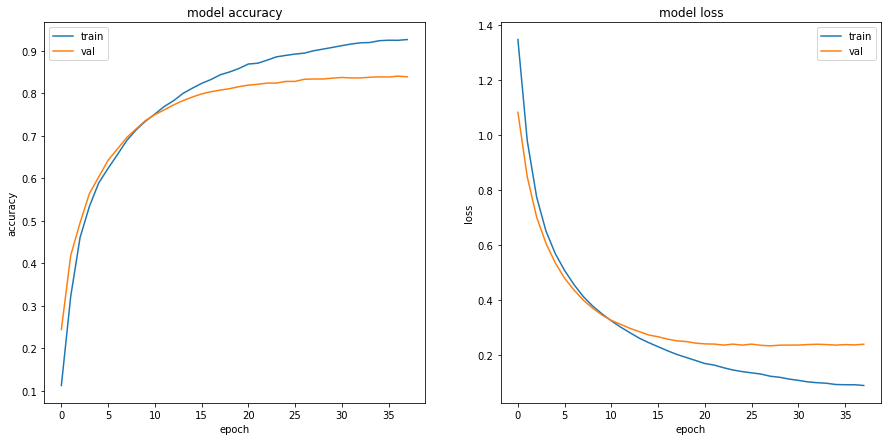

In [126]:
plot_history(history_v3)

# Evaluation

In [46]:
label_tokenizer.word_index

{'nn': 1,
 'in': 2,
 'nnp': 3,
 'dt': 4,
 'nns': 5,
 'jj': 6,
 ',': 7,
 '.': 8,
 'cd': 9,
 'vbd': 10,
 'rb': 11,
 'vb': 12,
 'cc': 13,
 'to': 14,
 'vbn': 15,
 'vbz': 16,
 'prp': 17,
 'vbg': 18,
 'vbp': 19,
 'md': 20,
 'pos': 21,
 'prp$': 22,
 '$': 23,
 '``': 24,
 "''": 25,
 ':': 26,
 'wdt': 27,
 'jjr': 28,
 'nnps': 29,
 'wp': 30,
 'rp': 31,
 'jjs': 32,
 'wrb': 33,
 'rbr': 34,
 '-rrb-': 35,
 '-lrb-': 36,
 'ex': 37,
 'rbs': 38,
 'pdt': 39,
 '#': 40,
 'wp$': 41,
 'ls': 42,
 'fw': 43,
 'uh': 44,
 'sym': 45}

In [47]:
y_test_classes = [np.argmax(y, axis=-1) for y in Y_test]
labels_to_consider = np.unique(y_test_classes)
puntuaction_classes = [0,7,8,23,24,25,26,35,36,40,45]
#puntuaction_classes = [0,1,2,3,4,5,6,7,8,45]
classification_label = []
for lb in labels_to_consider:
    if not lb in puntuaction_classes:
        classification_label.append(lb)
        
classification_label

[1,
 2,
 3,
 4,
 5,
 6,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 37,
 38,
 39,
 41]

In [48]:
l = [el for el in classification_label]
correct_labels = []
for key, i in label_tokenizer.word_index.items():
    if i in l:
        correct_labels.append(key)

In [49]:
Y_test_flatten = (np.concatenate(y_test_classes))

In [136]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def print_classification_matrix(y_pred_flatten, normalize = None, values_format='g'):
    #finally print the confusion matrix for the best model 

    cm = confusion_matrix(Y_test_flatten, y_pred_flatten, labels = classification_label, normalize = normalize)

    plt.figure(figsize = (30,20))
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt=values_format, ax=ax); 

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(correct_labels) 
    ax.yaxis.set_ticklabels(correct_labels);

## Model Variation 2

In [71]:
loss, accuracy = model_v2.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

21/21 [==============================] - 2s 112ms/step - loss: 0.1996 - acc: 0.8559
Loss: 0.19959460198879242,
Accuracy: 0.8559021949768066


In [72]:
Y_pred_v2 = np.argmax(model_v2.predict(X_test), axis = -1)

21/21 [==============================] - 3s 131ms/step


In [73]:
Y_pred_flatten_v2 = Y_pred_v2.flatten()

In [74]:
report_test_v2 = classification_report(Y_test_flatten, Y_pred_flatten_v2, zero_division = 0, labels = classification_label)
print(report_test_v2)

              precision    recall  f1-score   support

           1       0.82      0.77      0.79      2383
           2       0.99      0.96      0.97      1630
           3       0.76      0.71      0.74      1504
           4       0.99      0.99      0.99      1335
           5       0.66      0.78      0.71       941
           6       0.59      0.76      0.66       918
           9       0.95      0.84      0.89       858
          10       0.89      0.83      0.86       634
          11       0.75      0.75      0.75       381
          12       0.84      0.95      0.89       403
          13       1.00      1.00      1.00       366
          14       1.00      1.00      1.00       386
          15       0.70      0.68      0.69       366
          16       0.86      0.86      0.86       280
          17       0.99      0.98      0.99       192
          18       0.65      0.56      0.60       221
          19       0.81      0.78      0.79       134
          20       0.97    

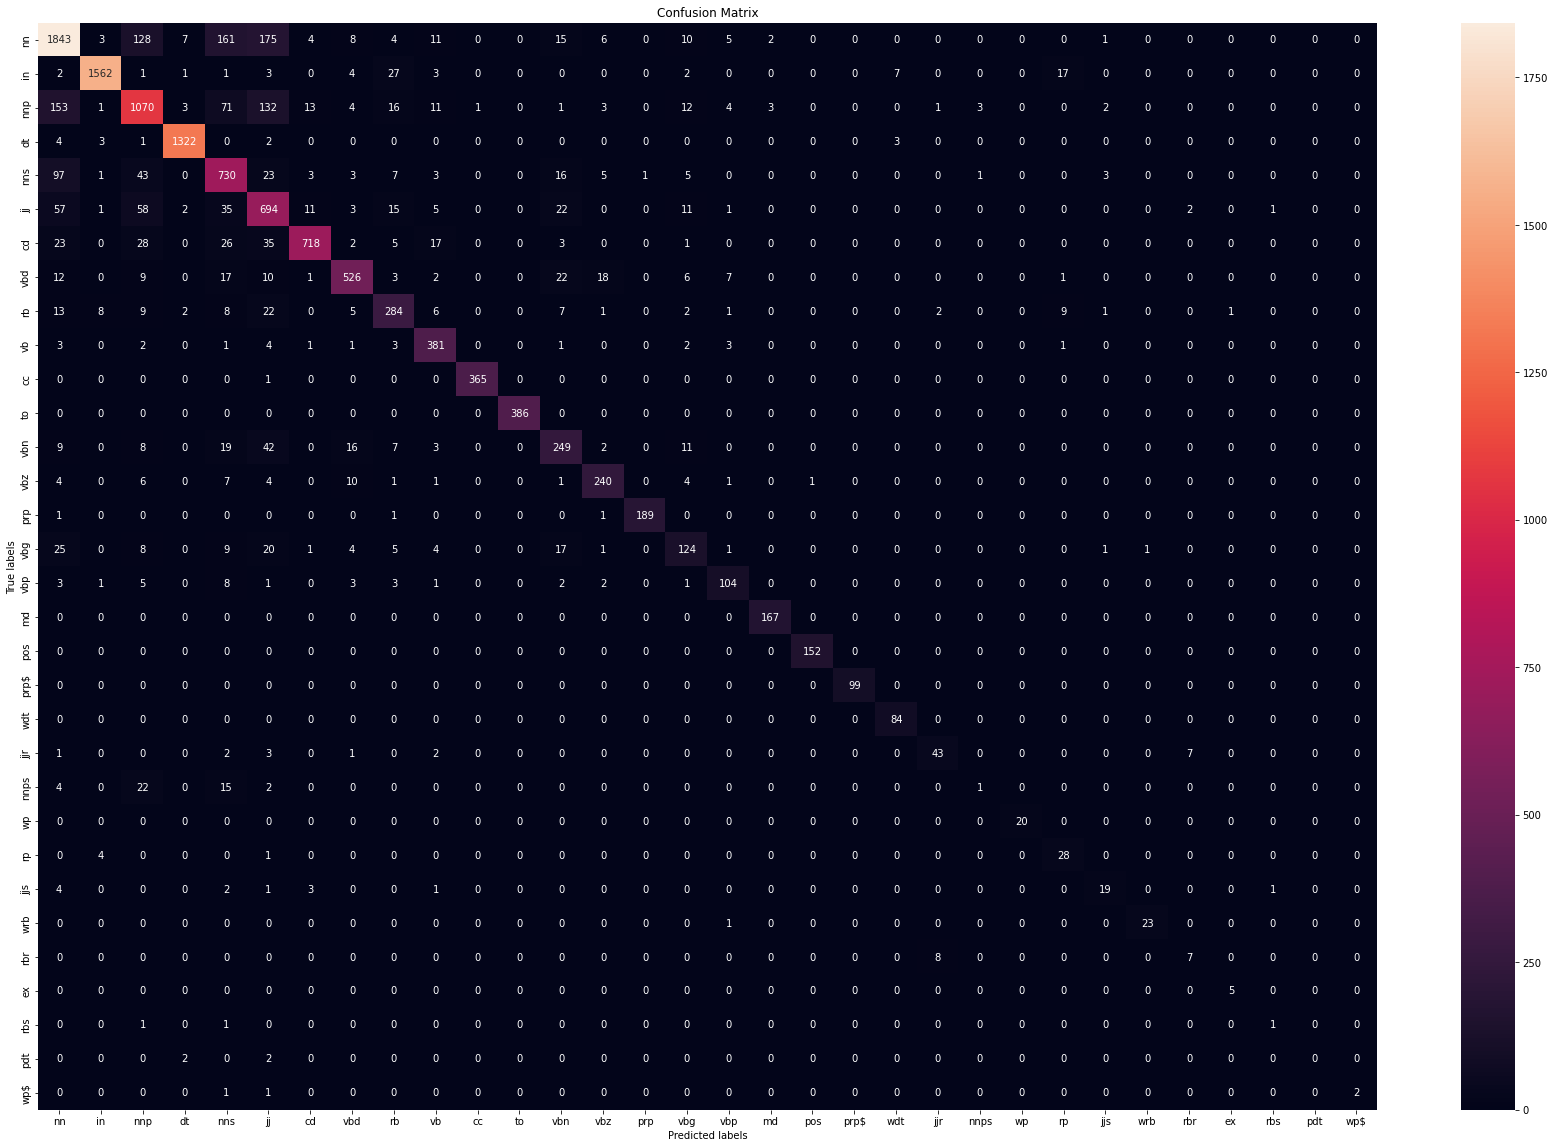

In [75]:
print_classification_matrix(Y_pred_flatten_v2)

## Model Variation 3

In [104]:
loss, accuracy = model_v3.evaluate(X_test, Y_test, verbose = 1)
print("Loss: {0},\nAccuracy: {1}".format(loss, accuracy))

21/21 [==============================] - 2s 73ms/step - loss: 0.2122 - acc: 0.8523
Loss: 0.2122238725423813,
Accuracy: 0.8522997498512268


In [127]:
Y_pred_v3 = np.argmax(model_v3.predict(X_test), axis = -1)

21/21 [==============================] - 4s 75ms/step


In [128]:
Y_pred_flatten_v3 = Y_pred_v3.flatten()

In [129]:
report_test_v3 = classification_report(Y_test_flatten, Y_pred_flatten_v3, zero_division = 0, labels = classification_label)
print(report_test_v3)

              precision    recall  f1-score   support

           1       0.78      0.77      0.78      2383
           2       0.98      0.95      0.97      1630
           3       0.04      0.67      0.08      1504
           4       0.98      0.99      0.99      1335
           5       0.65      0.75      0.70       941
           6       0.58      0.70      0.63       918
           9       0.94      0.84      0.88       858
          10       0.87      0.83      0.85       634
          11       0.70      0.77      0.73       381
          12       0.80      0.94      0.86       403
          13       0.99      1.00      0.99       366
          14       1.00      1.00      1.00       386
          15       0.71      0.69      0.70       366
          16       0.83      0.87      0.85       280
          17       0.99      0.99      0.99       192
          18       0.58      0.57      0.57       221
          19       0.79      0.77      0.78       134
          20       0.97    

CONFUSION MATRIX NOT NORMALIZED


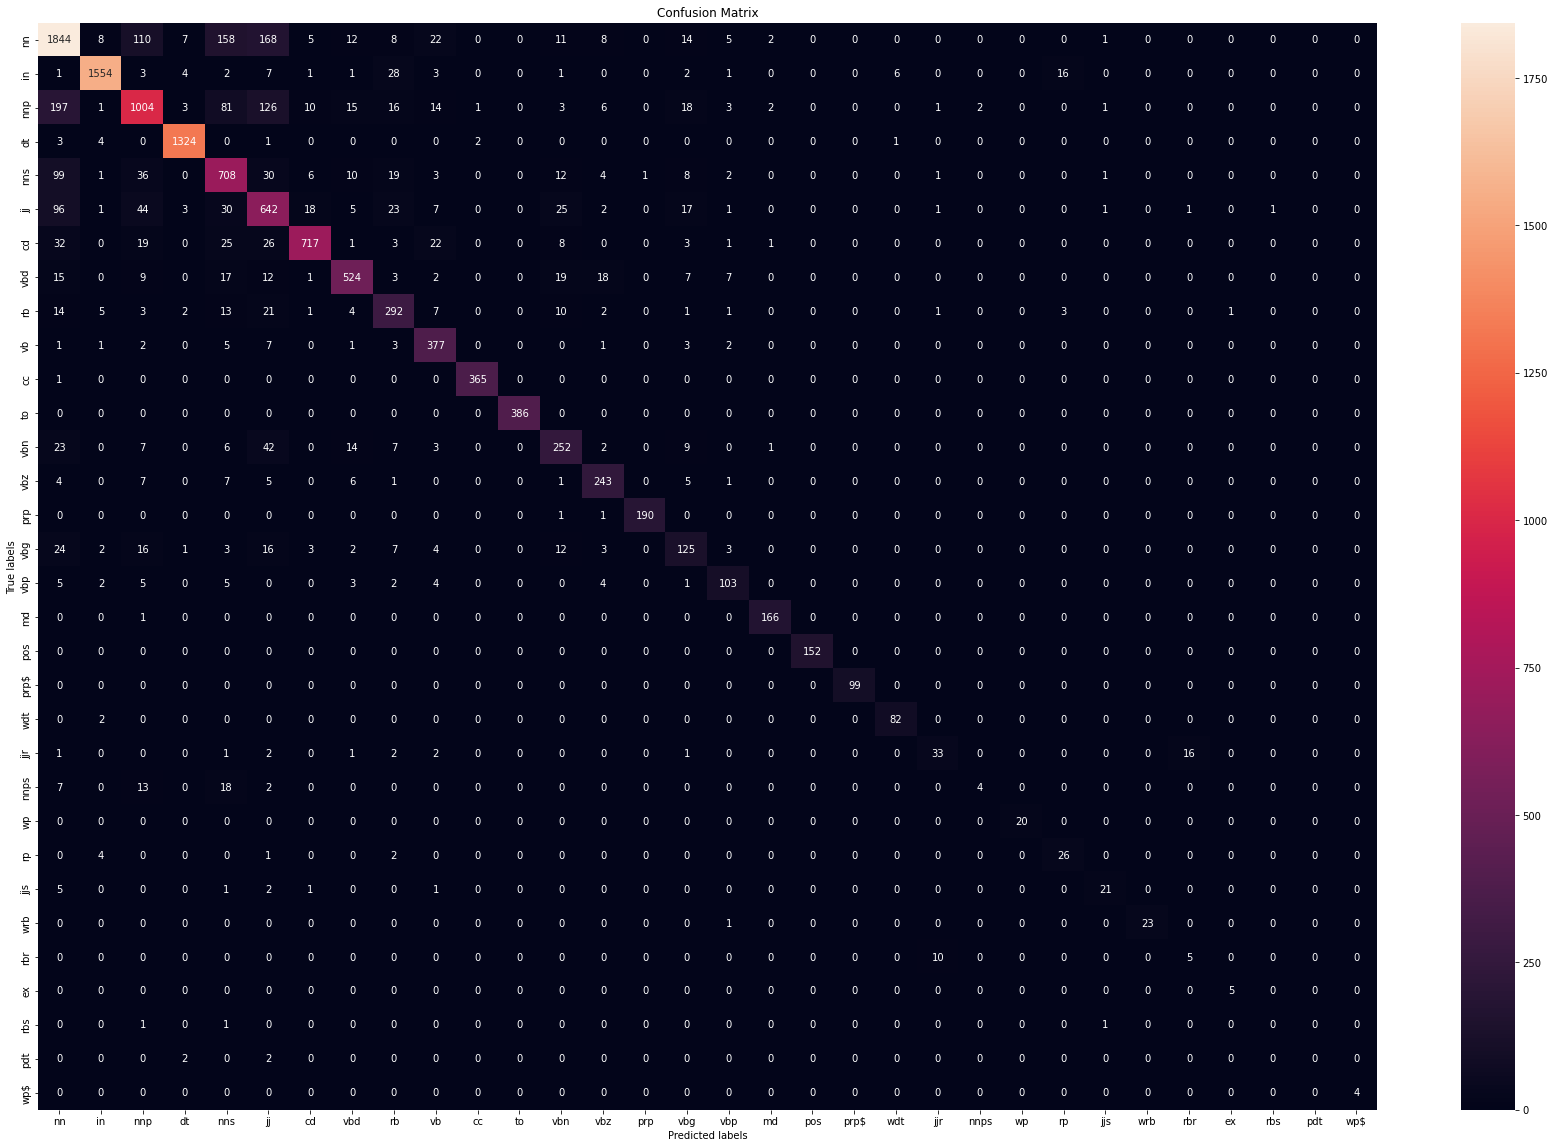

In [139]:
print_classification_matrix(Y_pred_flatten_v3)

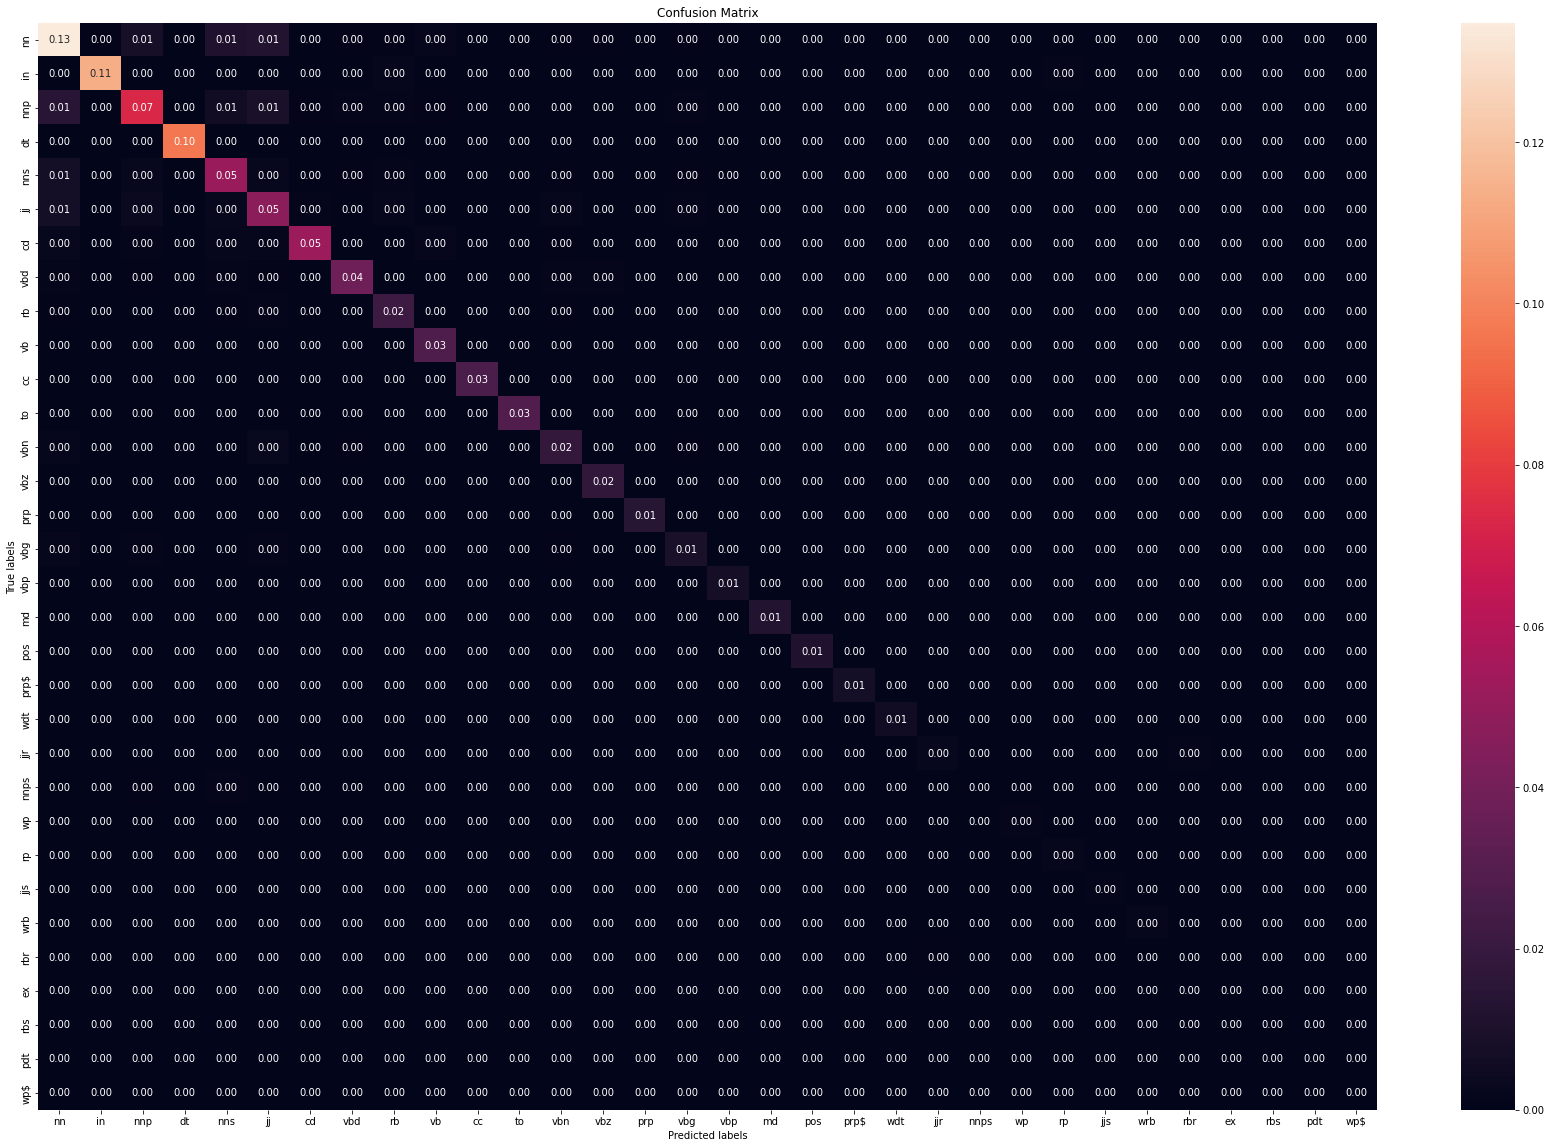

In [140]:
# CONFUSION MATRIX NORMALIZED
print_classification_matrix(Y_pred_flatten_v3, 'all', ".2f")